In [0]:
import pickle
import boto3
import re
import json
import pandas as pd
import unicodedata
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StringType, FloatType, ArrayType, DoubleType, StructType, StructField,LongType

In [0]:
base_save_path = "{save_path_for_openalex_tables}"
iteration_save_path = "{save_path_for_most_data}"
model_data_path = "{higher_level_iteration_save_path}"

### Getting all data

In [0]:
classification_labels = spark.read.parquet(f'{model_data_path}topic_labels_data_from_cwts_new')
classification_labels.cache().count()

4521

In [0]:
classification_labels.sample(0.1).show(1, truncate=False)

+----------------+-----------------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------+
|micro_cluster_id|short_label      |long_label                           |keywords                                                                                                                                          |summary                                                                                      

#### Taking into account merged works (to make sure all data is correctly labeled)

In [0]:
work_merges = spark.read.parquet(f"{iteration_save_path[:-15]}/work_merges_dist")\
    .select('paper_id',F.col('merge_into_id').alias('paper_id_merge_into')).dropDuplicates(subset=['paper_id'])
work_merges.cache().count()

12559467

In [0]:
new_topic_labels = spark.read.parquet(f'{model_data_path}topics_data_from_cwts_new') \
        .select(F.col('work_id').cast(LongType()).alias('paper_id'), 
                F.col('macro_cluster_id').cast(IntegerType()),
                F.col('meso_cluster_id').cast(IntegerType()),
                F.col('micro_cluster_id').cast(IntegerType())) \
        .filter(F.col('paper_id').isNotNull() & 
                F.col('macro_cluster_id').isNotNull() & 
                F.col('meso_cluster_id').isNotNull() & 
                F.col('micro_cluster_id').isNotNull()) \
        .join(classification_labels, how='inner', on='micro_cluster_id') \
        .join(work_merges, how='left', on='paper_id') \
        .withColumn('new_paper_id', F.when(F.col('paper_id_merge_into').isNotNull(), 
                                           F.col('paper_id_merge_into')).otherwise(F.col('paper_id'))) \
        .select('micro_cluster_id', F.col('new_paper_id').alias('paper_id'), 'macro_cluster_id', 'meso_cluster_id', 
                'short_label', 'long_label', 'keywords', 'summary', 'wikipedia_url')
        
new_topic_labels.cache().count()

70674439

#### Looking at amount of labeled data for each topic

In [0]:
new_topic_labels.groupby('micro_cluster_id').count().select(F.max('count'), F.min('count')).show()

+----------+----------+
|max(count)|min(count)|
+----------+----------+
|    167455|      1000|
+----------+----------+



In [0]:
cite_counts_to_use = topic_counts \
    .withColumn('cite_counts_thresh', get_number_of_core_citations_for_cluster(F.col('count'))) \
    .select('micro_cluster_id', 'cite_counts_thresh')

In [0]:
new_citations = spark.read.parquet(f"{iteration_save_path[:-15]}/new_work_citations") \
    .dropDuplicates()

citations = spark.read.parquet(f"{base_save_path}static_citations") \
    .union(new_citations.select('paper_id','paper_reference_id')) \
    .dropDuplicates() \
    .join(new_concept_labels, how='inner', on='paper_id') \
    .select('paper_id', 'paper_reference_id', 
            F.col('micro_cluster_id').alias('micro_paper'))

citations.cache().count()

1601368869

### Quickly Looking at Unmatched CWTS data

In [0]:
incoming_citations_only = new_concept_labels.join(citations.dropDuplicates(subset=['paper_id']), how='left', on='paper_id') \
    .filter(F.col('paper_reference_id').isNull()) \
    .groupBy('micro_cluster_id').count().toPandas()

all_counts = new_concept_labels.groupBy('micro_cluster_id').count().select('micro_cluster_id', 
                                                                           F.col('count').alias('total_count')).toPandas()

In [0]:
full_df = incoming_citations_only.merge(all_counts, how='inner', on='micro_cluster_id')
full_df['percentage_missing'] = full_df['count']/full_df['total_count']

<Axes: xlabel='micro_cluster_id', ylabel='percentage_missing'>

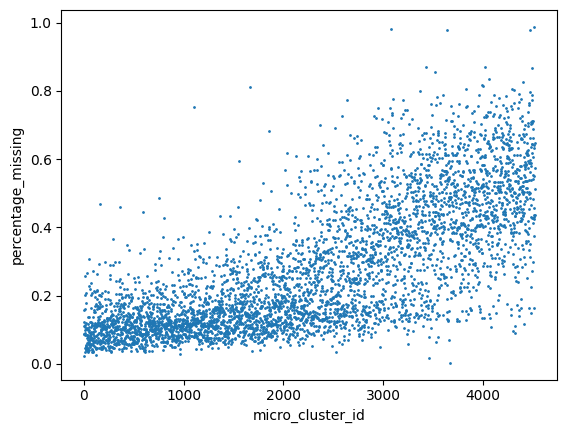

In [0]:
full_df.plot.scatter(x='micro_cluster_id', y ='percentage_missing', s=1)

This chart shows that as you get later on in the topic IDs, the labeled data starts to rely more heavily on incoming citations instead of outgoing citations. Since we are trying to assign these topics live as the work comes into our system, we will only be using outgoing citations. Therefore, it is good to know the effect this might have on our model. 

In [0]:
new_works = spark.read.parquet(f"s3://data-pull-from-justins-personal-s3/all_concepts_model_data/V4/exploration/new_work_titles") \
    .dropDuplicates(subset=['paper_id'])

works = spark.read.parquet(f"{base_save_path}static_works") \
    .select(*new_works.columns) \
    .union(new_works) \
    .dropDuplicates(subset=['paper_id'])


works.cache().count()

247623528

In [0]:
full_df = new_concept_labels.join(works.select('paper_id',F.year(F.col('publication_date')).alias('year')), how='inner', on='paper_id') \
    .groupBy('micro_cluster_id').agg(F.mean(F.col('year')).alias('year_mean')).toPandas()

<Axes: xlabel='micro_cluster_id', ylabel='year_mean'>

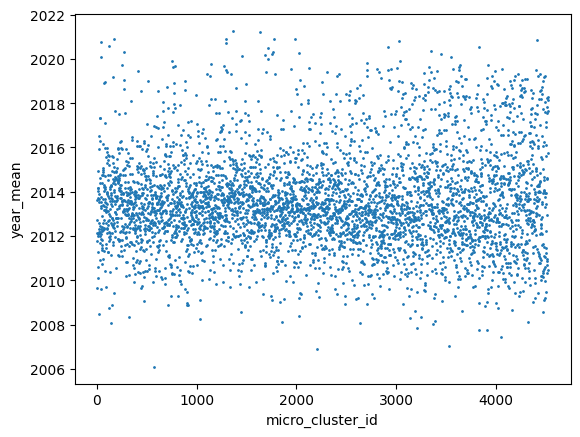

In [0]:
# new data
full_df.plot.scatter(x='micro_cluster_id', y ='year_mean', s=1)

This figure shows the average publication year for each cluster. As we can see, the data has about the same distribution for the lower IDs as for the higher IDs, although it does become more evenly distributed for the last 1000 cluster IDs.